In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/corona-virus-report/covid_19_clean_complete.csv
/kaggle/input/corona-virus-report/complete_data_new_format.csv


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from math import exp

data = pd.read_csv("/kaggle/input/corona-virus-report/complete_data_new_format.csv")
data.head()
data['Date'] =pd.to_datetime(data.Date)
country = data.iloc[:,1]
date = data.iloc[:,4]
confirmed = data.iloc[:,5]
deaths = data.iloc[:,6]
country_unique = set(country)
latest_country_cases =data[data['Date'] == max(data['Date'])].reset_index()
latest_country_cases=latest_country_cases.groupby(["Country/Region"])['Confirmed', 'Deaths'].sum().reset_index()



/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


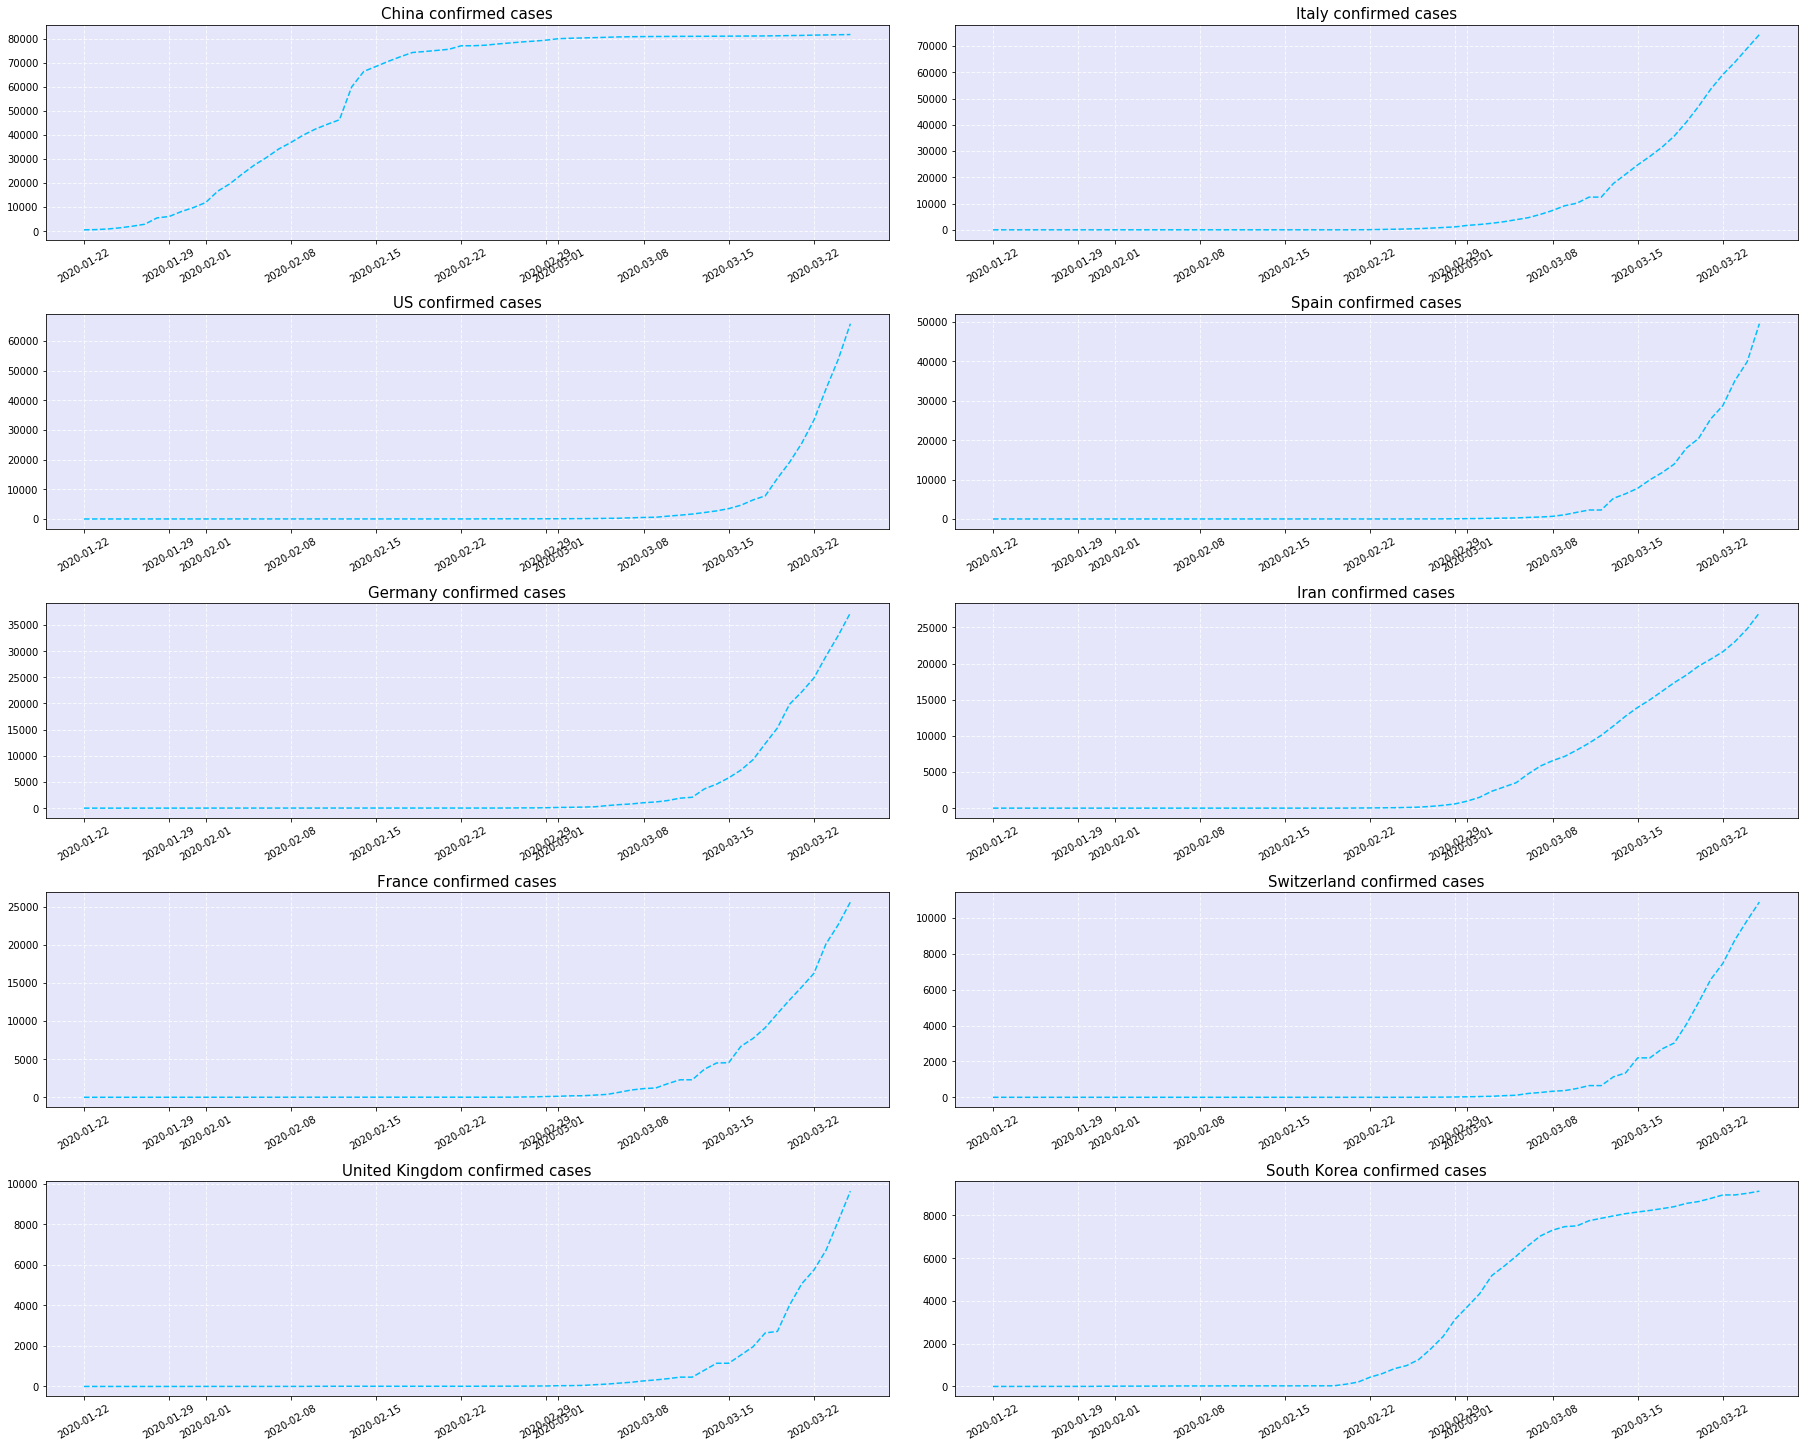

In [3]:
%matplotlib inline

top_10_countries = latest_country_cases.nlargest(10,['Confirmed']).reset_index(drop=True)
top_10_countries.style.background_gradient(cmap='Reds')
top_10_names = list(top_10_countries['Country/Region'])



plot_data = {}
fig, ax = plt.subplots(5,2, figsize=(25,20), constrained_layout=True)
ax = ax.flatten()

for  i, country in enumerate(top_10_names):
    plot_data[country] = data.loc[data['Country/Region'] == country]
    plot_data[country]=plot_data[country].groupby(["Date"]).sum().sort_values(by = ['Date']).reset_index()
    ax[i].plot(plot_data[country]['Date'], plot_data[country]['Confirmed'], linestyle = "--", color = 'deepskyblue')
    ax[i].set_title(country + ' confirmed cases', fontsize = 15)
    ax[i].set_facecolor('lavender')
    ax[i].grid(color='ghostwhite', linestyle='--', linewidth=1)
    ax[i].xaxis.set_tick_params(labelsize=10, rotation = 30)
    ax[i].yaxis.set_tick_params(labelsize=10)
    

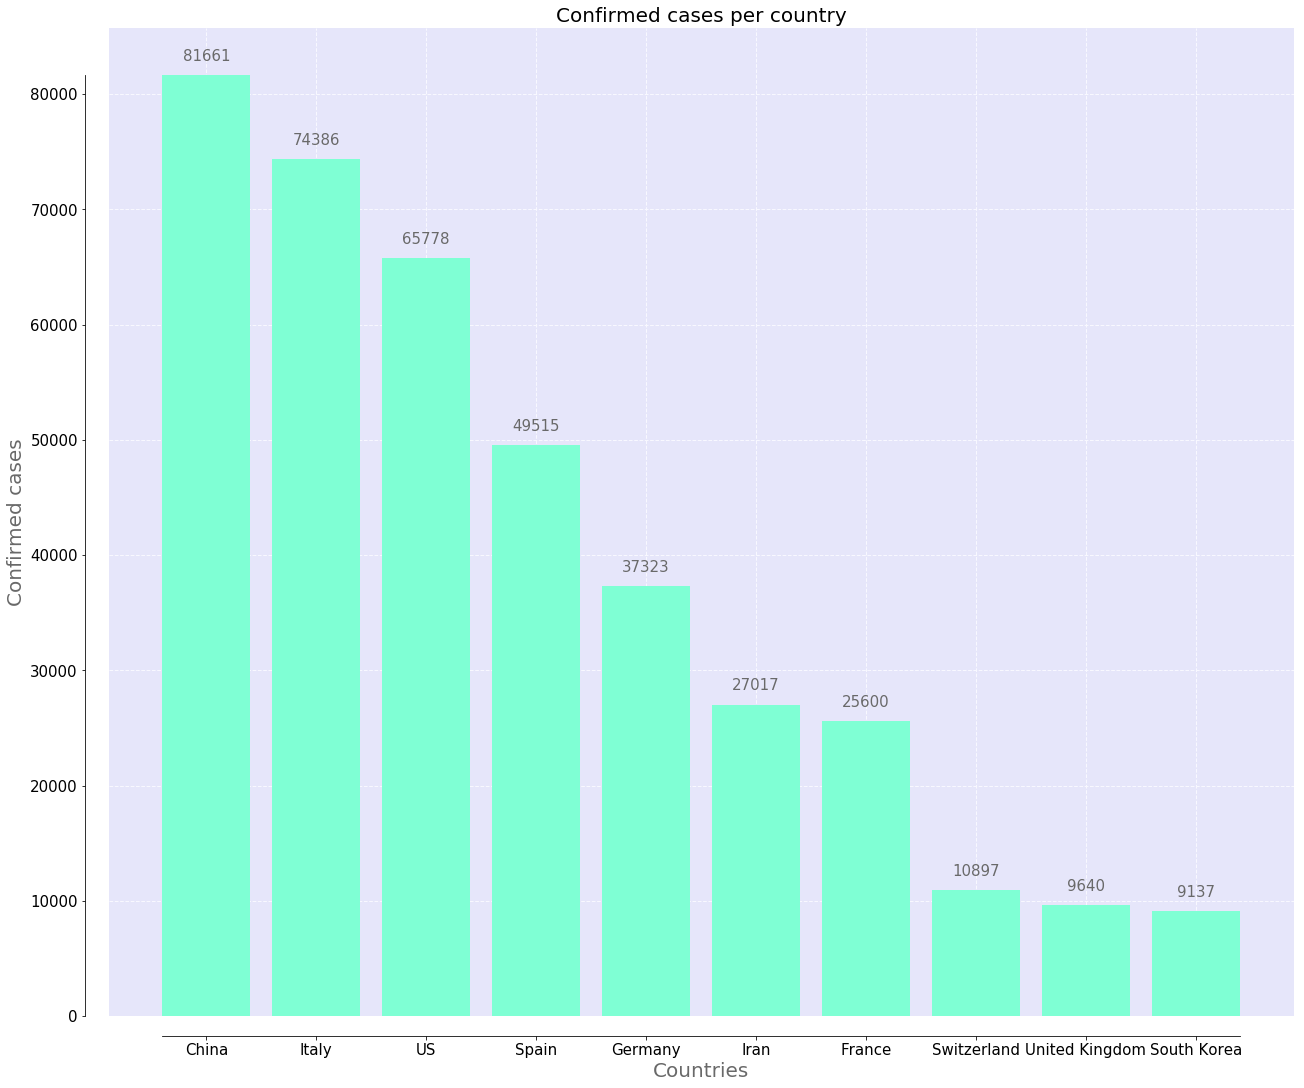

In [4]:
fig = plt.figure(figsize= [18,15],constrained_layout=True)
bar = plt.gca()
plt.bar(top_10_countries['Country/Region'], top_10_countries['Confirmed'], color = 'aquamarine')
bar.set_title('Confirmed cases per country', fontsize = 20)
bar.set_facecolor('lavender')
bar.set_axisbelow(True)
bar.set_xlabel('Countries', fontsize=20, color = 'dimgray')
bar.set_ylabel('Confirmed cases', fontsize=20, color = 'dimgray')
bar.xaxis.set_tick_params(labelsize=15)
bar.yaxis.set_tick_params(labelsize=15)

bar.grid(color='ghostwhite', linestyle='--', linewidth=1)
bar.spines['bottom'].set_position(('axes', -0.02))
bar.spines['left'].set_position(('axes', -0.02))
plt.rcParams['axes.edgecolor']='dimgrey'
bar.spines['top'].set_color('none')
bar.spines['right'].set_color('none')
bar.spines['left'].set_smart_bounds(True)
bar.spines['bottom'].set_smart_bounds(True)


for column in bar.patches:
    height = column.get_height()
    bar.text(column.get_x() + column.get_width()/2., height + 1000,
        int(height),
        ha='center', va='bottom', fontsize = 15, color = 'dimgray')


In [5]:
data_china = data.loc[data['Country/Region'] == 'China']
data_china= data_china.groupby(["Date"]).sum().sort_values(by = ['Date']).reset_index()

df_test = adfuller(data_china['Confirmed'], autolag='AIC')

print("Test statistic = {:.3f}".format(df_test[0]))
print("P-value is = {:.3f}".format(df_test[1]))
print("\u03B1:")
for k, v in df_test[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<df_test[0] else "", 100-int(k[:-1])))


Test statistic = -2.388
P-value is = 0.145
α:
	1%: -3.540522678829176 - The data is not stationary with 99% confidence
	5%: -2.9094272025108254 - The data is not stationary with 95% confidence
	10%: -2.5923136524453696 - The data is not stationary with 90% confidence


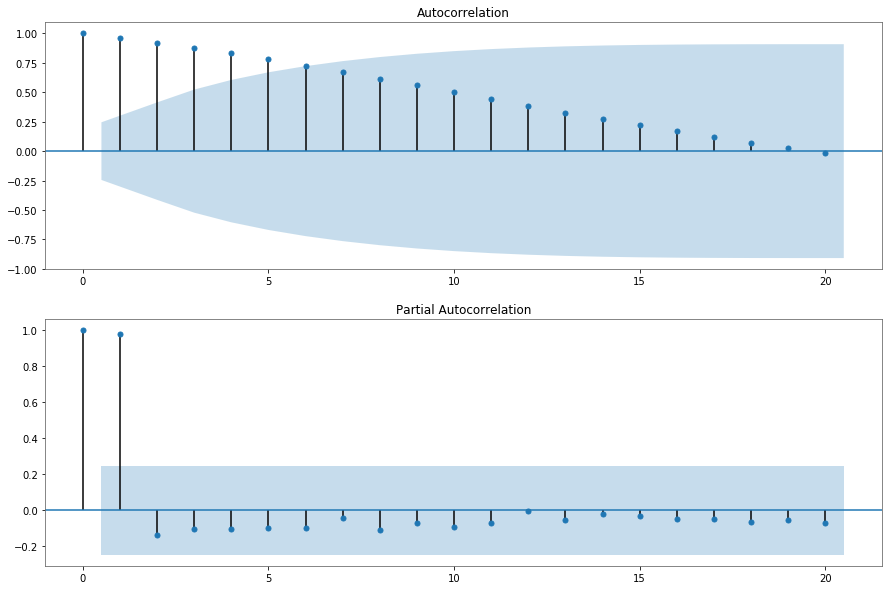

In [6]:
fig, ax = plt.subplots(2, figsize=(15,10))

ax[0] = plot_acf(data_china['Confirmed'], ax=ax[0], lags=20)
ax[1] = plot_pacf(data_china['Confirmed'], ax=ax[1], lags=20)

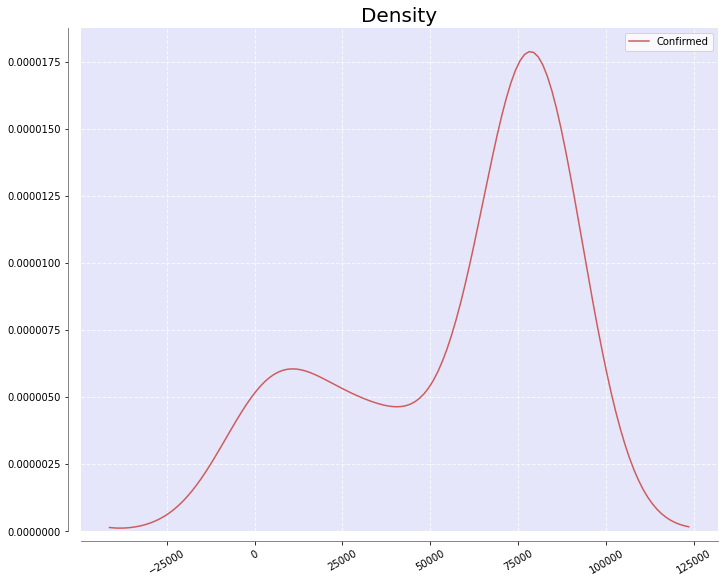

In [7]:
fig = plt.figure(figsize= [10,8],constrained_layout=True)

densityplot = sns.kdeplot(data_china['Confirmed'], color = 'indianred')
densityplot = plt.gca()
densityplot.set_title('Density', fontsize = 20)
densityplot.set_facecolor('lavender')
densityplot.grid(color='ghostwhite', linestyle='--', linewidth=1)
densityplot.spines['bottom'].set_position(('axes', -0.02))
densityplot.spines['left'].set_position(('axes', -0.02))
densityplot.spines['top'].set_color('none')
densityplot.spines['right'].set_color('none')
densityplot.xaxis.set_tick_params(rotation = 30)

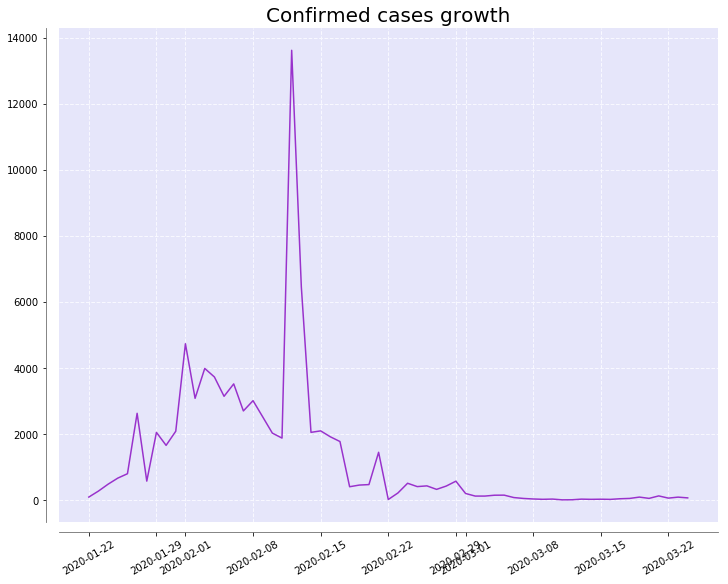

In [8]:
diff_china_confirmed = np.diff(data_china['Confirmed'])
date_china = data_china['Date'][:-1]

fig = plt.figure(figsize= [10,8],constrained_layout=True)
diff_plot = plt.gca()
plt.plot(date_china, diff_china_confirmed, color = 'darkorchid')
diff_plot.set_title('Confirmed cases growth', fontsize = 20)
diff_plot.set_facecolor('lavender')
diff_plot.grid(color='ghostwhite', linestyle='--', linewidth=1)
diff_plot.spines['bottom'].set_position(('axes', -0.02))
diff_plot.spines['left'].set_position(('axes', -0.02))
diff_plot.spines['top'].set_color('none')
diff_plot.spines['right'].set_color('none')
diff_plot.xaxis.set_tick_params(rotation = 30)

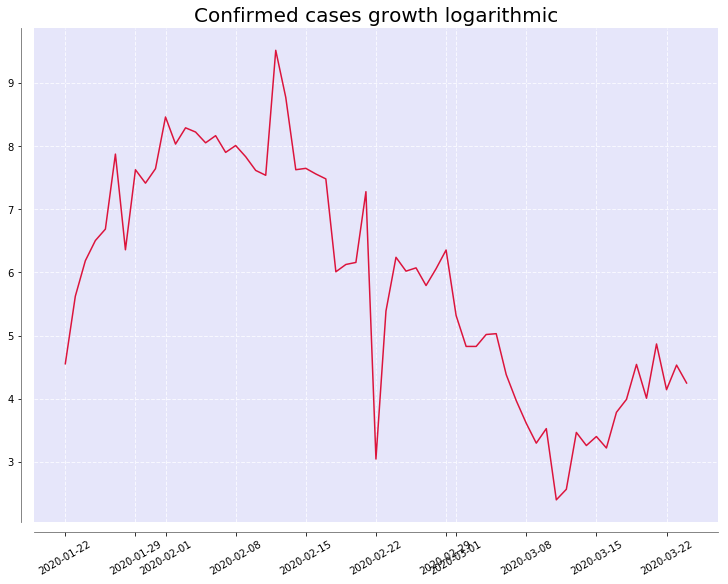

In [9]:
log_diff_china_confirmed = np.log(diff_china_confirmed)

fig = plt.figure(figsize= [10,8],constrained_layout=True)
log_plot = plt.gca()
plt.plot(date_china, log_diff_china_confirmed, color = 'crimson')
log_plot.set_title('Confirmed cases growth logarithmic', fontsize = 20)
log_plot.set_facecolor('lavender')
log_plot.grid(color='ghostwhite', linestyle='--', linewidth=1)
log_plot.spines['bottom'].set_position(('axes', -0.02))
log_plot.spines['left'].set_position(('axes', -0.02))
log_plot.spines['top'].set_color('none')
log_plot.spines['right'].set_color('none')
log_plot.xaxis.set_tick_params(rotation = 30)

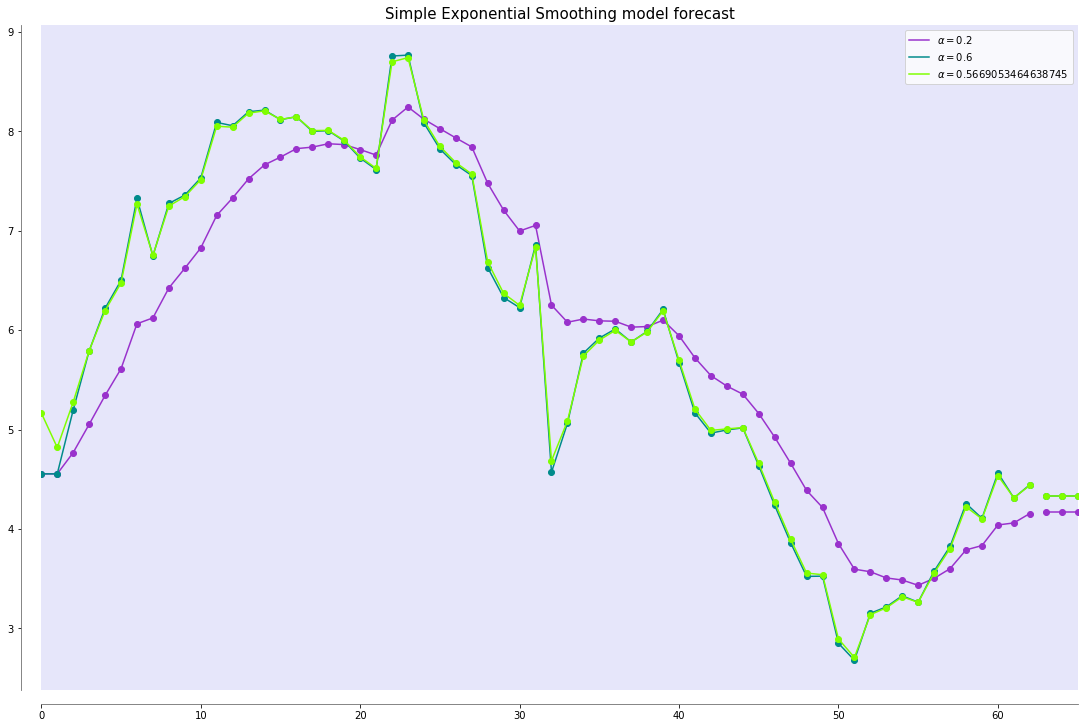

In [27]:
log_diff_china_confirmed_df = pd.DataFrame(log_diff_china_confirmed)

SES_02 = SimpleExpSmoothing(log_diff_china_confirmed_df).fit(smoothing_level=0.2,optimized=False)
forecast_02 = SES_02.forecast(3).rename(r'$\alpha=0.2$')

SES_06 = SimpleExpSmoothing(log_diff_china_confirmed_df).fit(smoothing_level=0.6,optimized=False)
forecast_06 = SES_06.forecast(3).rename(r'$\alpha=0.6$')

SES = SimpleExpSmoothing(log_diff_china_confirmed_df).fit()
forecast_SES = SES.forecast(3).rename(r'$\alpha=%s$'%SES.model.params['smoothing_level'])

fig = plt.figure(figsize= [10,8],constrained_layout=True)
SES_plot = fig.gca()
SES_plot.set_facecolor('lavender')
SES_plot.set_title('Simple Exponential Smoothing model forecast', fontsize = 15)
SES_plot.grid(color='ghostwhite', linestyle='--', linewidth=1)
SES_plot.spines['bottom'].set_position(('axes', -0.02))
SES_plot.spines['left'].set_position(('axes', -0.02))
SES_plot.spines['top'].set_color('none')
SES_plot.spines['right'].set_color('none')


forecast_02.plot(marker='o', color='darkorchid', legend=True)
SES_02.fittedvalues.plot(marker='o',  color='darkorchid')

forecast_06.plot(marker='o', color='darkcyan', legend=True)
SES_06.fittedvalues.plot(marker='o',  color='darkcyan')

forecast_SES.plot(marker='o', color='chartreuse', legend=True)
SES.fittedvalues.plot(marker='o',  color='chartreuse')

plt.show()

In [22]:
forecast_02_real = []
for forecast in forecast_02:
    real_forecast = exp(forecast)
    forecast_02_real.append(real_forecast)
    
    
forecast_06_real = []
for forecast in forecast_06:
    real_forecast = exp(forecast)
    forecast_06_real.append(real_forecast)


forecast_real = []
for forecast in forecast_SES:
    real_forecast = exp(forecast)
    forecast_real.append(real_forecast)

real_forecasts_China = {'Simple exponential smoothing alpha= 02': [forecast_02_real[1]], 'Simple exponential smoothing alpha= 06': [forecast_06_real[1]], 'Simple exponential smoothing alpha= auto': [forecast_real[1]]}
index = ['Forecast']
real_forecasts_China = pd.DataFrame(real_forecasts_China, index=index)
real_forecasts_China = real_forecasts_China.transpose()
print(real_forecasts_China)

                                           Forecast
Simple exponential smoothing alpha= 02    64.934895
Simple exponential smoothing alpha= 06    75.694316
Simple exponential smoothing alpha= auto  75.970558


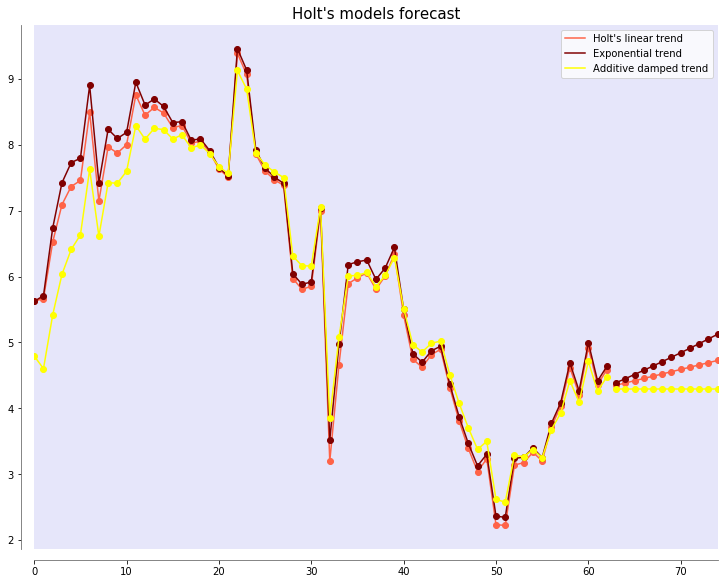

In [26]:
holt_linear = Holt(log_diff_china_confirmed_df).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
forecast_holt_linear = holt_linear.forecast(12).rename("Holt's linear trend")

holt_exponential = Holt(log_diff_china_confirmed_df, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
forecast_holt_exponential = holt_exponential.forecast(12).rename("Exponential trend")

holt_additive = Holt(log_diff_china_confirmed_df, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
forecast_holt_additive = holt_additive.forecast(12).rename("Additive damped trend")

fig = plt.figure(figsize= [10,8],constrained_layout=True)
Holt_plot = fig.gca()
Holt_plot.set_facecolor('lavender')
Holt_plot.set_title("Holt's models forecast", fontsize = 15)
Holt_plot.grid(color='ghostwhite', linestyle='--', linewidth=1)
Holt_plot.spines['bottom'].set_position(('axes', -0.02))
Holt_plot.spines['left'].set_position(('axes', -0.02))
Holt_plot.spines['top'].set_color('none')
Holt_plot.spines['right'].set_color('none')


forecast_holt_linear.plot(marker='o', color='tomato', legend=True)
holt_linear.fittedvalues.plot(marker='o',  color='tomato')

forecast_holt_exponential.plot(marker='o', color='maroon', legend=True)
holt_exponential.fittedvalues.plot(marker='o',  color='maroon')

forecast_holt_additive.plot(marker='o', color='yellow', legend=True)
holt_additive .fittedvalues.plot(marker='o',  color='yellow')

plt.show()

In [30]:
forecast_holt_linear_real = []
for forecast in forecast_holt_linear:
    real_forecast = exp(forecast)
    forecast_holt_linear_real.append(real_forecast)
    
    
forecast_holt_exponential_real = []
for forecast in forecast_holt_exponential:
    real_forecast = exp(forecast)
    forecast_holt_exponential_real.append(real_forecast)


forecast_holt_additive_real = []
for forecast in forecast_holt_additive:
    real_forecast = exp(forecast)
    forecast_holt_additive_real.append(real_forecast)
    
      

real_forecasts_China_Holt = {"Holt's linear trend": forecast_holt_linear_real, 'Exponential trend': forecast_holt_exponential_real, 'Additive damped trend': forecast_holt_additive_real}

index_Holt = []
for i in range(1,13):
    index_Holt.append('Forecast ' + str(i))
    

real_forecasts_China_Holt = pd.DataFrame(real_forecasts_China_Holt)
real_forecasts_China_Holt.index = index_Holt
print(real_forecasts_China_Holt)

             Holt's linear trend  Exponential trend  Additive damped trend
Forecast 1             77.499084          80.426521              73.280051
Forecast 2             80.198134          85.604804              73.280051
Forecast 3             82.991185          91.197388              73.280051
Forecast 4             85.881508          97.242820              73.280051
Forecast 5             88.872492         103.783696              73.280051
Forecast 6             91.967643         110.867131              73.280051
Forecast 7             95.170589         118.545284              73.280051
Forecast 8             98.485083         126.875964              73.280051
Forecast 9            101.915010         135.923301              73.280051
Forecast 10           105.464391         145.758510              73.280051
Forecast 11           109.137386         156.460757              73.280051
Forecast 12           112.938300         168.118138              73.280051
